In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [2]:
def fetch_earthquake_data(datemin='2025-09-15', datemax='2025-10-14', latmax=46,
                        lonmin=123, lonmax=146, latmin=24, magmin=0, fmt='html', nmax=1000):
    """
    Fetch earthquake data from GEOFON for Japan region.
    """
    base_url = 'https://geofon.gfz.de/eqinfo/list.php'
    
    params = {
        'datemin': datemin,
        'datemax': datemax,
        'latmax': latmax,
        'lonmin': lonmin,
        'lonmax': lonmax,
        'latmin': latmin,
        'magmin': magmin,
        'fmt': fmt,
        'nmax': nmax
    }
    
    print(f"Fetching data from {base_url}...")
    response = requests.get(base_url, params=params)
    response.raise_for_status()  # Raise an error for bad status codes
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the earthquake list container
    eqlist = soup.find('div', {'id': 'eqlist'})
    if not eqlist:
        print("No earthquake data found in the response")
        return pd.DataFrame()
    
    earthquakes = []
    
    # Each earthquake is in a div with class "flex-row row eqinfo-all"
    # Find even and odd rows separately
    evn_event_rows = soup.find_all('div', class_='flex-row row eqinfo-all evnrow')
    odd_event_rows = soup.find_all('div', class_='flex-row row eqinfo-all oddrow')
    
    # Create alternating sequence: first from even, then odd, then even, etc.
    event_rows = []
    max_length = max(len(evn_event_rows), len(odd_event_rows))
    
    for i in range(max_length):
        if i < len(evn_event_rows):
            event_rows.append(evn_event_rows[i])
        if i < len(odd_event_rows):
            event_rows.append(odd_event_rows[i])
    
    for row in event_rows:
        try:
            # Extract magnitude from the magbox span
            mag_span = row.find('span', class_='magbox')
            if not mag_span:
                continue
            magnitude = float(mag_span.get_text(strip=True))
            
            # Extract region from the strong tag
            region_strong = row.find('strong')
            if not region_strong:
                continue
            region = region_strong.get_text(strip=True)
            
            # Extract coordinates from the title attribute
            region_div = row.find('div', title=True)
            coordinates = region_div.get('title', '') if region_div else ''
            
            latitude = None
            longitude = None
            if coordinates:
                try:
                    # Split by comma
                    parts = coordinates.split(', ')
                    if len(parts) == 2:
                        lon_part = parts[0].replace('°E', '').replace('°W', '')
                        lat_part = parts[1].replace('°N', '').replace('°S', '')
                        longitude = float(lon_part)
                        latitude = float(lat_part)
                except (ValueError, IndexError):
                    pass
            
            # Extract time and depth from the second row
            time_depth_row = row.find_all('div', class_='row')[1]
            time_depth_text = time_depth_row.get_text(strip=True)
            
            # Parse time and depth
            # checking the format: "2025-10-11 14:24:22.4 (≤2 h ago) 86*"
            time_text = ""
            depth_text = ""
            
            # Split by the pull-right span to separate time and depth
            time_span = time_depth_row.find('span', class_='pull-right')
            if time_span:
                # Remove the pull-right span to get time
                time_span.extract()
                time_text = time_depth_row.get_text(strip=True)
                # Clean up time text (remove relative time info)
                time_text = str(time_text.split('(')[0].strip().split('.')[0].strip())
                depth_text = str(time_span.get_text(strip=True).replace('*', '').strip())
            else:
                # Fallback: try to extract from the full text
                time_text = str(time_depth_text.split('(')[0].strip().split('.')[0].strip())
                
                import re
                depth_match = re.search(r'(\d+)\*?$', time_depth_text)
                if depth_match:
                    depth_text = str(depth_match.group(1))
            
            # Extract event ID from the parent link
            parent_link = row.find_parent('a')
            event_id = ""
            if parent_link and parent_link.get('href'):
                href = parent_link.get('href')
                # Extract ID from URL like "event.php?id=gfz2025tydw"
                if 'id=' in href:
                    event_id = href.split('id=')[1]
            
            earthquakes.append({
                'Magnitude': magnitude,
                'Region': region,
                'DateTime_UTC': time_text,
                'Depth_km': depth_text if depth_text else None,
                'Latitude': latitude,
                'Longitude': longitude,
                'Event_ID': event_id
            })
            
        except (ValueError, AttributeError, IndexError) as e:
            print(f"Error parsing earthquake data: {e}")
            continue
    
    df = pd.DataFrame(earthquakes)
    
    print(f"Successfully fetched {len(df)} earthquake records")
    return df

In [3]:
# you can use this function with different parameters to get different data
# df = fetch_earthquake_data(
#     datemin='2024-03-02',
#     datemax='2025-10-11',
#     magmin=5.0 , # Only earthquakes with magnitude 5.0 or higher
#     nmax=500
# )
# you can use this function to get all the data based on the default parameters
# df = fetch_earthquake_data(datemin='2025-01-01')
df = fetch_earthquake_data(datemin='2025-09-15')
print("\nEarthquake Data:")
df.tail(10)


Fetching data from https://geofon.gfz.de/eqinfo/list.php...
Successfully fetched 25 earthquake records

Earthquake Data:


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID
15,4.6,"Off East Coast of Honshu, Japan",2025-10-01 17:40:51,10,37.81,144.12,gfz2025tgdi
16,4.7,"Off East Coast of Honshu, Japan",2025-09-28 01:36:38,10,37.70,144.17,gfz2025szla
17,4.8,"Southwestern Ryukyu Islands, Japan",2025-09-28 21:23:51,58,24.34,123.31,gfz2025taye
18,4.2,"Near East Coast of Honshu, Japan",2025-09-24 18:03:16,54,38.92,142.14,gfz2025stjo
19,4.8,"Off East Coast of Honshu, Japan",2025-09-27 13:37:19,10,37.79,144.14,gfz2025synh
20,4.9,"Ryukyu Islands, Japan",2025-09-20 04:46:35,10,24.11,126.12,gfz2025slbg
21,4.8,"Ryukyu Islands, Japan",2025-09-23 17:08:13,133,28.89,128.73,gfz2025srmg
22,5.0,"Ryukyu Islands, Japan",2025-09-17 12:55:07,33,29.60,129.71,gfz2025sgew
23,4.6,"Ryukyu Islands, Japan",2025-09-17 13:00:34,52,29.42,129.93,gfz2025sgfb
24,4.8,"Near East Coast of Honshu, Japan",2025-09-15 04:34:46,50,38.41,142.11,gfz2025sbxj


In [4]:
# Save data to CSV file
df.to_csv('JAPAN_GEOFON.csv', index=False, encoding='utf-8')
print("Data saved to 'JAPAN_GEOFON.csv'")

Data saved to 'JAPAN_GEOFON.csv'


# Working On Data With Pandas Library

In [5]:
import pandas as pd

csv_path = 'JAPAN_GEOFON.csv'
df_csv = pd.read_csv(csv_path)
print('Loaded CSV:', csv_path)
print('Shape (rows, cols):', df_csv.shape)
df_csv.head()


Loaded CSV: JAPAN_GEOFON.csv
Shape (rows, cols): (25, 7)


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID
0,4.6,"Southeast of Honshu, Japan",2025-10-14 23:29:10,442,30.41,138.27,gfz2025ueij
1,4.8,"Near West Coast of Honshu, Japan",2025-10-14 03:34:24,10,39.66,139.42,gfz2025ucuy
2,4.7,"Near East Coast of Honshu, Japan",2025-10-13 03:25:47,63,38.66,142.42,gfz2025uaze
3,4.8,"Ryukyu Islands, Japan",2025-10-11 14:24:22,86,27.17,127.70,gfz2025tydw
4,4.8,"Southeast of Honshu, Japan",2025-10-11 03:22:02,445,30.39,138.44,gfz2025txia


In [6]:
# split Time from date, Conver to numeric floats
import numpy as np

# expected_cols = ['DateTime_UTC', 'Magnitude', 'Depth_km', 'Latitude', 'Longitude', 'Region']
# missing_cols = [c for c in expected_cols if c not in df_csv.columns]
# if missing_cols:
#     print('Warning - missing columns in CSV:', missing_cols)


# Parse to datetime (coerce errors to NaT)
# df_csv['DateTime_UTC'] = pd.to_datetime(df_csv['DateTime_UTC'], errors='coerce', utc=True)
df_csv['DateTime_UTC'] = pd.to_datetime(df_csv['DateTime_UTC'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

# # Create Time column (HH:MM:SS) in UTC
# Time = df_csv['DateTime_UTC'].dt.strftime('%H:%M:%S')
# df_csv['Time'] = Time

# Keep only the date part in DateTime_UTC
# df_csv['DateTime_UTC'] = df_csv['DateTime_UTC'].dt.floor('D')

# Convert numeric to floats
# for col in ['Magnitude', 'Depth_km', 'Latitude', 'Longitude']:
#     df_csv[col] = pd.to_numeric(df_csv[col], errors='coerce')


df_csv["Depth_km"] = df_csv["Depth_km"].astype("float")

print('Dtypes after conversion:')
print(df_csv.dtypes)
df_csv.head()


Dtypes after conversion:
Magnitude              float64
Region                  object
DateTime_UTC    datetime64[ns]
Depth_km               float64
Latitude               float64
Longitude              float64
Event_ID                object
dtype: object


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID
0,4.6,"Southeast of Honshu, Japan",2025-10-14 23:29:10,442.0,30.41,138.27,gfz2025ueij
1,4.8,"Near West Coast of Honshu, Japan",2025-10-14 03:34:24,10.0,39.66,139.42,gfz2025ucuy
2,4.7,"Near East Coast of Honshu, Japan",2025-10-13 03:25:47,63.0,38.66,142.42,gfz2025uaze
3,4.8,"Ryukyu Islands, Japan",2025-10-11 14:24:22,86.0,27.17,127.70,gfz2025tydw
4,4.8,"Southeast of Honshu, Japan",2025-10-11 03:22:02,445.0,30.39,138.44,gfz2025txia


In [7]:
# Handling missing values

before_na_counts = df_csv.isna().sum()
before_rows = len(df_csv)
print('Missing values before handling:')
print(before_na_counts)

# Drop rows with critical missing data
critical_cols = ['DateTime_UTC', 'Magnitude', 'Region']
df_clean = df_csv.dropna(subset=critical_cols).copy()

# new strategy to fill the missing values
if df_clean['Depth_km'].isna().any():
    median_depth = df_clean['Depth_km'].median()
    df_clean['Depth_km'] = df_clean['Depth_km'].fillna(median_depth)


after_na_counts = df_clean.isna().sum()
after_rows = len(df_clean)
print('\nRows before:', before_rows, 'Rows after:', after_rows)
print('Dropped rows:', before_rows - after_rows)
print('\nMissing values after handling:')
print(after_na_counts)

# Use cleaned df for further analysis
df_work = df_clean
print('\nData types now:')
print(df_work.dtypes)


Missing values before handling:
Magnitude       0
Region          0
DateTime_UTC    0
Depth_km        0
Latitude        0
Longitude       0
Event_ID        0
dtype: int64

Rows before: 25 Rows after: 25
Dropped rows: 0

Missing values after handling:
Magnitude       0
Region          0
DateTime_UTC    0
Depth_km        0
Latitude        0
Longitude       0
Event_ID        0
dtype: int64

Data types now:
Magnitude              float64
Region                  object
DateTime_UTC    datetime64[ns]
Depth_km               float64
Latitude               float64
Longitude              float64
Event_ID                object
dtype: object


In [8]:
# Create Month column

# df_work['Month'] = df_work['DateTime_UTC'].dt.to_period('M').astype(str)
df_work['Month'] = df_work['DateTime_UTC'].dt.month_name()
print('Added Month column. Unique months:', sorted(df_work['Month'].unique()))
# df_work[['DateTime_UTC','Time','Month']].head()
df_work.head()

Added Month column. Unique months: ['October', 'September']


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID,Month
0,4.6,"Southeast of Honshu, Japan",2025-10-14 23:29:10,442.0,30.41,138.27,gfz2025ueij,October
1,4.8,"Near West Coast of Honshu, Japan",2025-10-14 03:34:24,10.0,39.66,139.42,gfz2025ucuy,October
2,4.7,"Near East Coast of Honshu, Japan",2025-10-13 03:25:47,63.0,38.66,142.42,gfz2025uaze,October
3,4.8,"Ryukyu Islands, Japan",2025-10-11 14:24:22,86.0,27.17,127.70,gfz2025tydw,October
4,4.8,"Southeast of Honshu, Japan",2025-10-11 03:22:02,445.0,30.39,138.44,gfz2025txia,October


In [9]:
# Create Category column

bins = [-np.inf, 4, 6, np.inf]
labels = ['Weak', 'Moderate', 'Strong']
df_work['Category'] = pd.cut(df_work['Magnitude'], bins=bins, labels=labels, right=False)
print('Category value counts:')
print(df_work['Category'].value_counts(dropna=False))
df_work[['Magnitude','Category']].head()


Category value counts:
Category
Moderate    25
Weak         0
Strong       0
Name: count, dtype: int64


,Magnitude,Category
0,4.6,Moderate
1,4.8,Moderate
2,4.7,Moderate
3,4.8,Moderate
4,4.8,Moderate


In [10]:
# Group by Month and Category, calculate mean and count

agg_month_cat = (df_work
                 .groupby(['Month','Category'])
                 .agg(mean_magnitude=('Magnitude','mean'),
                      mean_depth_km=('Depth_km','mean'),
                      count=('Magnitude','count'))
                 .reset_index())
print('Aggregated by Month and Category:')
agg_month_cat


Aggregated by Month and Category:


/var/folders/y_/9c6h8__s5pb54qrf3kgp725r0000gn/T/ipykernel_3987/3743031519.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Month','Category'])


,Month,Category,mean_magnitude,mean_depth_km,count
0,October,Weak,NaN,NaN,0
1,October,Moderate,4.806250,114.000000,16
2,October,Strong,NaN,NaN,0
3,September,Weak,NaN,NaN,0
4,September,Moderate,4.733333,45.555556,9
5,September,Strong,NaN,NaN,0


In [11]:
# Rename Region to Place

df_work = df_work.rename(columns={"Region":"Place"})

In [12]:
# Extract name_area from Region - first part before comma. I dont get how to handle region regarding the question 

# df_work['name_area'] = df_work['Region'].astype(str).str.split(',').str[0].str.strip()
# print('Extracted name_area. Sample:')
# df_work[['Region','name_area']].head()
df_work['Region'] = df_work['Place'].astype(str).str.split(',').str[0].str.strip()
print('Extracted Region. Sample:')
df_work[['Place','Region']].head()

Extracted Region. Sample:


,Place,Region
0,"Southeast of Honshu, Japan",Southeast of Honshu
1,"Near West Coast of Honshu, Japan",Near West Coast of Honshu
2,"Near East Coast of Honshu, Japan",Near East Coast of Honshu
3,"Ryukyu Islands, Japan",Ryukyu Islands
4,"Southeast of Honshu, Japan",Southeast of Honshu


In [13]:
df_work.head()

,Magnitude,Place,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID,Month,Category,Region
0,4.6,"Southeast of Honshu, Japan",2025-10-14 23:29:10,442.0,30.41,138.27,gfz2025ueij,October,Moderate,Southeast of Honshu
1,4.8,"Near West Coast of Honshu, Japan",2025-10-14 03:34:24,10.0,39.66,139.42,gfz2025ucuy,October,Moderate,Near West Coast of Honshu
2,4.7,"Near East Coast of Honshu, Japan",2025-10-13 03:25:47,63.0,38.66,142.42,gfz2025uaze,October,Moderate,Near East Coast of Honshu
3,4.8,"Ryukyu Islands, Japan",2025-10-11 14:24:22,86.0,27.17,127.70,gfz2025tydw,October,Moderate,Ryukyu Islands
4,4.8,"Southeast of Honshu, Japan",2025-10-11 03:22:02,445.0,30.39,138.44,gfz2025txia,October,Moderate,Southeast of Honshu


In [14]:
# Group by area: count, mean, max

area_stats = (df_work
              .groupby('Region')
              .agg(
                  num_quakes=('Event_ID','count'),
                  mean_magnitude=('Magnitude','mean'),
                  mean_depth_km=('Depth_km','mean'),
                  max_magnitude=('Magnitude','max'),
                  max_depth_km=('Depth_km','max')
              )
              .sort_values('num_quakes', ascending=False)
             )
print('Area-level statistics:')
area_stats.head(20)

Area-level statistics:


,num_quakes,mean_magnitude,mean_depth_km,max_magnitude,max_depth_km
Region,,,,,
Near East Coast of Honshu,7,4.728571,60.571429,5.1,103.0
Off East Coast of Honshu,7,4.785714,10.000000,5.0,10.0
Ryukyu Islands,6,4.900000,54.000000,5.3,133.0
Southeast of Honshu,2,4.700000,443.500000,4.8,445.0
Bonin Islands,1,4.500000,461.000000,4.5,461.0
Near West Coast of Honshu,1,4.800000,10.000000,4.8,10.0
Southwestern Ryukyu Islands,1,4.800000,58.000000,4.8,58.0


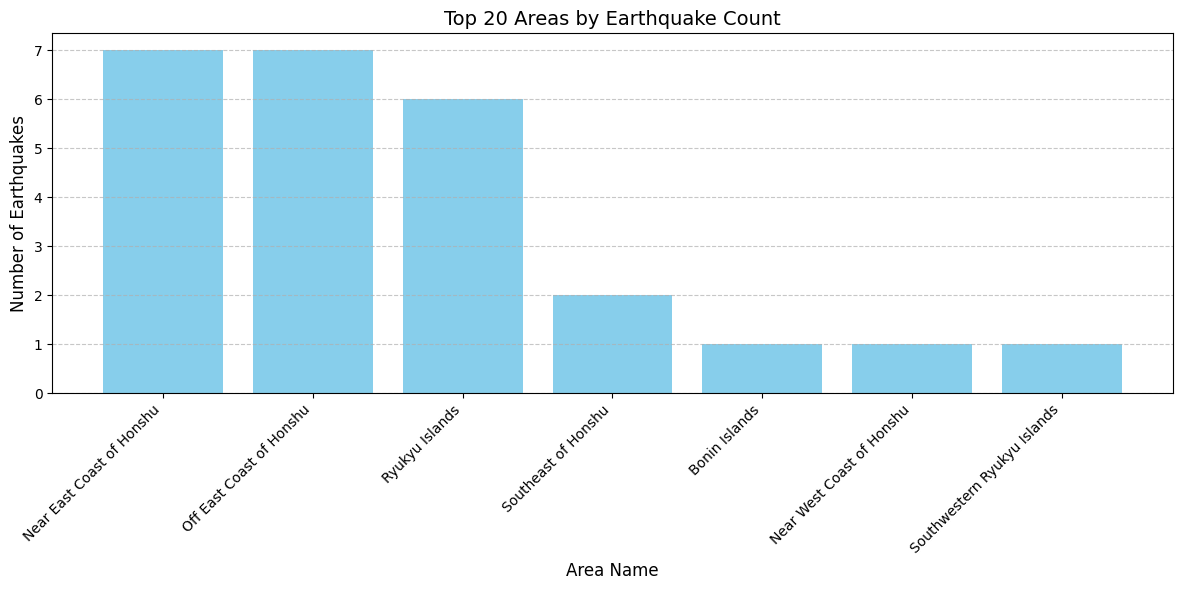

In [15]:
import matplotlib.pyplot as plt

# just Select the top 20 areas for plotting
top_20_areas = area_stats.head(20)
plt.figure(figsize=(12, 6))
plt.bar(top_20_areas.index, top_20_areas['num_quakes'], color='skyblue')
plt.xlabel('Area Name', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.title('Top 20 Areas by Earthquake Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('earthquake_counts_by_area_barchart.png')
# plt.close() 

In [16]:
# print(f"\nTotal earthquakes: {len(df)}")
# print(f"\nMagnitude range: {df['Magnitude'].min()} - {df['Magnitude'].max()}")
# print(f"\nRegion distribution:")
# print(df['Region'].value_counts())
# print(f"\nDataFrame Info:")
# print(df.info())
# print(f"\nSample data with all columns:")
# # print(df.head())
# df.head()


## Numpy Analysis

### Part1: Calculating Distance from Tokyo

#### Latitude & Longitude for Tokyo, Japan

In [17]:
tokyo_latitude, tokyo_longitude  = 35.6764, 139.6500

#### Distance calculations

In [18]:
# distance = np.sqrt(
# (df_work["Latitude"] - tokyo_latitude)**2 +
# (df_work["Longitude"] - tokyo_longitude)**2  
# ).round(2)

# df_work.insert(6, "Dist_to_Tokyo_km", value=distance)


# OR
earthquake_lat = np.radians(df_work["Latitude"])
earthquake_lng = np.radians(df_work["Longitude"])
tokyo_lat = np.radians(tokyo_latitude)
tokyo_lng = np.radians(tokyo_longitude)

dlat = earthquake_lat - tokyo_lat
dlng = earthquake_lng - tokyo_lng

a = np.sin(dlat / 2)**2 + np.cos(earthquake_lat) * np.cos(tokyo_lat) * np.sin(dlng / 2)**2
c = 2 * np.arcsin(np.sqrt(a))

# Radius of Earth in km = 6371.00
distance = (c * 6371).round(2)
df_work.insert(6, "Dist_to_Tokyo_km", value=distance)

### Part2: Earthquake Magnitude Analysis

#### Date Range for this Analysis

In [19]:
start_date = df_work.iloc[-1,2]
start_date = str(start_date).split()[0]
end_date = df_work.iloc[0,2]
end_date = str(end_date).split()[0]
print(f"From {start_date} to {end_date}")

From 2025-09-15 to 2025-10-14


#### Earthquake Magnitude Average

In [20]:
mag_average = np.mean(df_work["Magnitude"])
print(f"Average magnitude for earthquakes from {start_date} to {end_date} was {mag_average:.2f}")

Average magnitude for earthquakes from 2025-09-15 to 2025-10-14 was 4.78


#### Earthquake Magnitude Variance & Standard Deviation

In [21]:
mag_std_dev = np.std(df_work["Magnitude"])
mag_var = mag_std_dev ** 2
print(f"Variance of magnitude for earthquakes from {start_date} to {end_date} was {mag_var:.2f}")
print(f"Standard deviation of magnitude for earthquakes from {start_date} to {end_date} was {mag_std_dev:.2f}")

Variance of magnitude for earthquakes from 2025-09-15 to 2025-10-14 was 0.04
Standard deviation of magnitude for earthquakes from 2025-09-15 to 2025-10-14 was 0.20


#### Earthquake Magnitude Percentile

In [22]:
mag_p25 = np.percentile(df_work["Magnitude"], 25)
mag_p50 = np.percentile(df_work["Magnitude"], 50)
mag_p75 = np.percentile(df_work["Magnitude"], 75)
print(f"From {start_date} to {end_date} magnitude for:")
print(f"25% of earthquakes was equal or less than {mag_p25:.2f}")
print(f"50% of earthquakes was equal or less than {mag_p50:.2f}")
print(f"75% of earthquakes was equal or less than {mag_p75:.2f}")

From 2025-09-15 to 2025-10-14 magnitude for:
25% of earthquakes was equal or less than 4.70
50% of earthquakes was equal or less than 4.80
75% of earthquakes was equal or less than 4.80


## Exporting cleaned data 

In [24]:

df_work.to_csv('JAPAN_GEOFON_cleaned.csv' , encoding='utf-8-sig', index=False)